<a href="https://colab.research.google.com/github/HMendesDev/Data-Science/blob/main/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro, spearmanr, pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

# Carregando e Conhecendo os dados

In [2]:
arq = "/content/drive/MyDrive/Data Science/Regressão/house_price_regression_dataset.csv"

In [3]:
df = pd.read_csv(arq, sep=",") # Carregando os dados

In [4]:
df.head() # 5 primeiras linhas

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06


In [5]:
df.tail() # 5 últimas linhas

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
995,3261,4,1,1978,2.165110,2,10,701493.997069
996,3179,1,2,1999,2.977123,1,10,683723.160704
997,2606,4,2,1962,4.055067,0,2,572024.023634
998,4723,5,2,1950,1.930921,0,7,964865.298639
999,3268,4,2,1983,3.108790,2,2,742599.253332


In [6]:
df.columns # Colunas de nosso dataset

Index(['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built',
       'Lot_Size', 'Garage_Size', 'Neighborhood_Quality', 'House_Price'],
      dtype='object')

# Limpeza e Transformação

In [7]:
df[df.duplicated()] # Verificando registros duplicados

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price


In [8]:
df.isnull().sum().sum() # Verificando registros nulos

np.int64(0)

In [9]:
df.shape[0] * df.shape[1] # Quantidade de registros em nosso dataset

8000

Nosso dataset não tem linhas duplicadas e nem registros nulos, porém vamos explorar posteriormente se encontramos registros sujos ou seja aqueles que não apresentam uma informação válida do dado em si e temos no total 8000 mil registros

In [10]:
df.info() # Verificando informações do dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Square_Footage        1000 non-null   int64  
 1   Num_Bedrooms          1000 non-null   int64  
 2   Num_Bathrooms         1000 non-null   int64  
 3   Year_Built            1000 non-null   int64  
 4   Lot_Size              1000 non-null   float64
 5   Garage_Size           1000 non-null   int64  
 6   Neighborhood_Quality  1000 non-null   int64  
 7   House_Price           1000 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 62.6 KB


Nosso dataset consiste em 8 variáveis, 1 delas sendo a variável target (House_price) e 7 delas que são características que podem influenciar na nossa variável target, vamos conhecer:

Square_Footage: Tamanho da casa em metros quadrados

Num_Bedrooms: O número de quartos na casa

Num_Bathrooms: O número de banheiros na casa

Year_Built: Ano em que construiu a casa

Lot_Size: Tamanho do lote em que a casa foi construida medida em acre

Garage_Size: Quantidade de carros que cabem na garagem

Neighborhood_Quality: Classificação da qualidade do bairro em uma escala de 1 a 10

House_Price: O preço da casa (target) em reais

Vamos criar uma nova variável a partir de outra que pode influenciar e nos ajudar em nosso modelo de previsão:
A nova variável vai ser a idade da casa em anos, atualmente estamos no ano de 2025, casas mais novas tendem a ter um preço maior

In [11]:
df["Age_House"] = 2025 - df["Year_Built"] # Criando nova variável

In [12]:
# Vamos transformar nossa variável preditora com apenas 2 casas após a virgula
df["House_Price"] = df["House_Price"].apply(lambda x: round(x, 2))

Nossa variável "Lot_Size" Tamanho do lote em que a casa foi construida está sendo representado pela medida acre, que equivale (1 acre = 4046 metros quadrados) aproximado

Vamos transformar para uma medida metros quadrados

In [13]:
df["Lot_Size"] = df["Lot_Size"].apply(lambda x: x * 4046) # Transformando a variável

# Análise Exploratória

In [14]:
# Conhecendo as medidas descritivas das variáveis
df.describe()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price,Age_House
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000
mean,2815.422000,2.990000,1.973000,1986.550000,11240.141731,1.022000,5.615000,6.188610e+05,38.450000
std,1255.514921,1.427564,0.820332,20.632916,5251.316129,0.814973,2.887059,2.535681e+05,20.632916
min,503.000000,1.000000,1.000000,1950.000000,2047.511555,0.000000,1.000000,1.116269e+05,3.000000
25%,1749.500000,2.000000,1.000000,1969.000000,6740.416503,0.000000,3.000000,4.016482e+05,20.750000
50%,2862.500000,3.000000,2.000000,1986.000000,11368.209705,1.000000,6.000000,6.282673e+05,39.000000
75%,3849.500000,4.000000,3.000000,2004.250000,15873.742252,2.000000,8.000000,8.271413e+05,56.000000
max,4999.000000,5.000000,3.000000,2022.000000,20186.718725,2.000000,10.000000,1.108237e+06,75.000000


<Axes: xlabel='Square_Footage', ylabel='Count'>

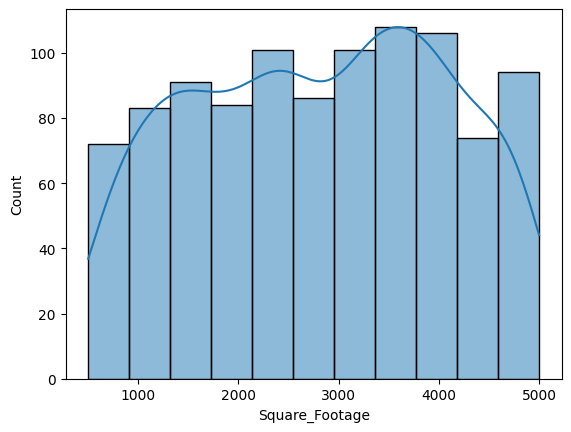

In [15]:
# Variável Square_Footage
sns.histplot(data=df, x="Square_Footage", kde=True)

In [16]:
# Média
df["Square_Footage"].mean()

np.float64(2815.422)

In [17]:
# Mediana
df["Square_Footage"].median()

2862.5

In [18]:
# Desvio padrão
df["Square_Footage"].std()

1255.5149205133457

In [19]:
# Coeficiente de variação
df["Square_Footage"].std() / df["Square_Footage"].mean() * 100

np.float64(44.59420010617753)

Será se a variável Square_Footage influencia no preço da casa?

<Axes: xlabel='House_Price', ylabel='Square_Footage'>

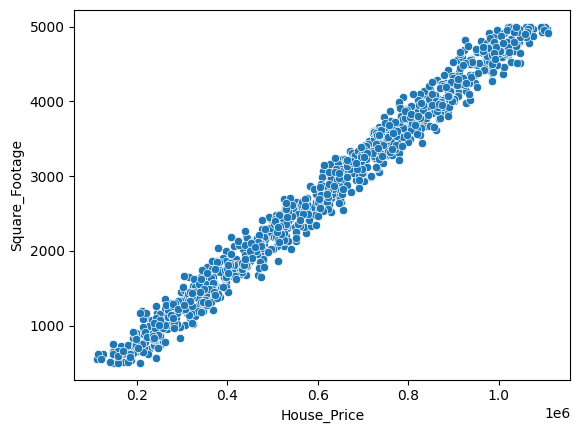

In [20]:
# Gráfico de dispersão
sns.scatterplot(data=df, y="Square_Footage", x="House_Price")

In [21]:
# Teste de hipótese
H0 = "Não há relação entre a variável Square_Footage e House_Price"
Ha = "Há relação entre a variável Square_Footage e House_Price"

Antes de realizar o teste de hipótese precisamos verificar se vamos usar um teste paramétrico ou não paramétrico

In [22]:
# Teste de hipótese de distribuição normal
teste_square = shapiro(df["Square_Footage"])
teste_price = shapiro(df["House_Price"])

if teste_price.pvalue < 0.05 and teste_square.pvalue < 0.05:
  print("Nossas variáveis não são normais, devemos usar um teste não paramétrico")
else:
  print("Nossas variáveis são normais, vamos usar um teste paramétrico")

Nossas variáveis não são normais, devemos usar um teste não paramétrico


In [23]:
teste_h = spearmanr(df["Square_Footage"], df["House_Price"])

if teste_h.pvalue < 0.05:
  print(f"Rejeitamos a Hipótese nula: {H0}")
  print(f"E seguimos com Hipótese alternativa: {Ha}")

Rejeitamos a Hipótese nula: Não há relação entre a variável Square_Footage e House_Price
E seguimos com Hipótese alternativa: Há relação entre a variável Square_Footage e House_Price


In [24]:
teste_h.correlation

np.float64(0.9916017947296666)

Temos uma correlação forte e com direção positiva ou seja a medida que a casa tem maior metragem em metros quadrados o preço tende a ser maior

Qual a média de metros quadrados para casas com quantidade de banheiros e quartos diferentes?

In [25]:
# Media de metros quadrados das casas por quantidades de quartos
df.groupby("Num_Bedrooms")["Square_Footage"].agg(["mean","median"]).reset_index()

,Num_Bedrooms,mean,median
0,1,2876.482587,2989.0
1,2,2772.660465,2755.0
2,3,2997.192308,3216.5
3,4,2766.319797,2690.0
4,5,2686.209756,2656.0


In [26]:
# Media de metros quadrados das casas por quantidades de banheiros
df.groupby("Num_Bathrooms")["Square_Footage"].agg(["mean","median"]).reset_index()

,Num_Bathrooms,mean,median
0,1,2844.300000,2977.0
1,2,2852.981651,2935.0
2,3,2746.105263,2692.0


Será se a quantidade de quartos e banheiros influencia no tamanho da casa em metros quadrados?

In [27]:
# Criando a variável Banheiros + Quartos
df["Bathrooms_Bedrooms"] = df["Num_Bedrooms"] + df["Num_Bathrooms"]

<Axes: xlabel='Bathrooms_Bedrooms', ylabel='Square_Footage'>

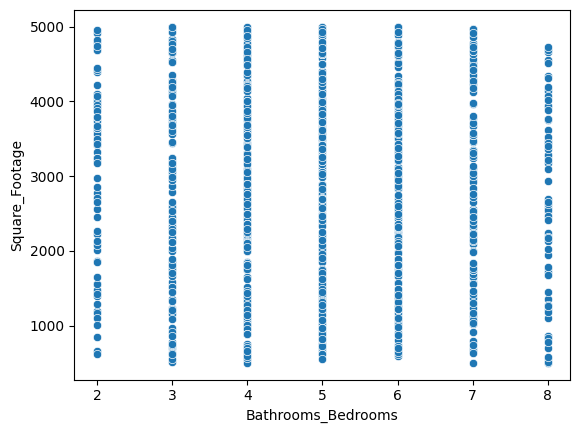

In [28]:
sns.scatterplot(data=df, y="Square_Footage", x="Bathrooms_Bedrooms")

In [29]:
# Teste de hipótese
H0 = "Não há relação entre a variável Square_Footage e Bathrooms_Bedrooms"
Ha = "Há relação entre a variável Square_Footage e Bathrooms_Bedrooms"

In [30]:
# Teste de hipótese de distribuição normal
teste_bath_beed = shapiro(df["Bathrooms_Bedrooms"])

if teste_bath_beed.pvalue < 0.05 and teste_square.pvalue < 0.05:
  print("Nossas variáveis não são normais, devemos usar um teste não paramétrico")
else:
  print("Nossas variáveis são normais, vamos usar um teste paramétrico")

Nossas variáveis não são normais, devemos usar um teste não paramétrico


In [31]:
teste_h2 = spearmanr(df["Square_Footage"], df["Bathrooms_Bedrooms"])

if teste_h2.pvalue < 0.05:
  print(f"Rejeitamos a Hipótese nula: {H0}")
  print(f"E seguimos com Hipótese alternativa: {Ha}")
else:
  print(f"Não rejeitamos a Hipótese nula: {H0}")

Não rejeitamos a Hipótese nula: Não há relação entre a variável Square_Footage e Bathrooms_Bedrooms


Realmente tanto pela visualização do gráfico de dispersão e o teste de hipótese, podemos deduzir que a partir de nossos dados a quantidade de quartos e banheiros na casa não influencia no tamanho da casa em metros quadrados

In [32]:
df.groupby("Bathrooms_Bedrooms")["Square_Footage"].agg(["mean","median"]).reset_index()

,Bathrooms_Bedrooms,mean,median
0,2,3046.116883,3324.0
1,3,2865.382353,2980.5
2,4,2836.164021,2827.0
3,5,2770.142180,2704.0
4,6,2762.953125,2718.0
5,7,2840.622951,2881.5
6,8,2652.068493,2651.0


Qual a quantidade de casas construidas em determinada faixa de ano?

In [33]:
# Calculo para encontar o melhor intervalo entre os dados
amplitude = df["Year_Built"].max() - df["Year_Built"].min()
linhas = round(math.sqrt(df.shape[0]))

In [34]:
# Encontrando o número natural para usar no calculo e achar o melhor intervalo entre os dados
for i in range(1,30,1):
  ic = round(amplitude + i) / linhas
  print(f"Número Natural {i}: {ic}")

Número Natural 1: 2.28125
Número Natural 2: 2.3125
Número Natural 3: 2.34375
Número Natural 4: 2.375
Número Natural 5: 2.40625
Número Natural 6: 2.4375
Número Natural 7: 2.46875
Número Natural 8: 2.5
Número Natural 9: 2.53125
Número Natural 10: 2.5625
Número Natural 11: 2.59375
Número Natural 12: 2.625
Número Natural 13: 2.65625
Número Natural 14: 2.6875
Número Natural 15: 2.71875
Número Natural 16: 2.75
Número Natural 17: 2.78125
Número Natural 18: 2.8125
Número Natural 19: 2.84375
Número Natural 20: 2.875
Número Natural 21: 2.90625
Número Natural 22: 2.9375
Número Natural 23: 2.96875
Número Natural 24: 3.0
Número Natural 25: 3.03125
Número Natural 26: 3.0625
Número Natural 27: 3.09375
Número Natural 28: 3.125
Número Natural 29: 3.15625


In [35]:
# Número natural igual deve ser a 24
ic = round(amplitude + 24) / linhas

In [36]:
# Definindo os intervalos que vão ser usados
bins = [df["Year_Built"].min()] # Inicializa o min da variável
cont = 0
while bins[cont] < df["Year_Built"].max():
    aux = bins[cont] + ic
    bins.append(aux)
    cont += 1

In [37]:
# Criando os labels de intervalo
labels = [f"{int(bins[i])} - {int(bins[i+1])}" for i in range(len(bins) - 1)]

In [38]:
# Mapeando os intervalos (labels) no dataframe a partir da variável "Year_Built"
df["Year_Built_Interval"] = pd.cut(df["Year_Built"], bins=bins,
                                   labels=labels,right=False)

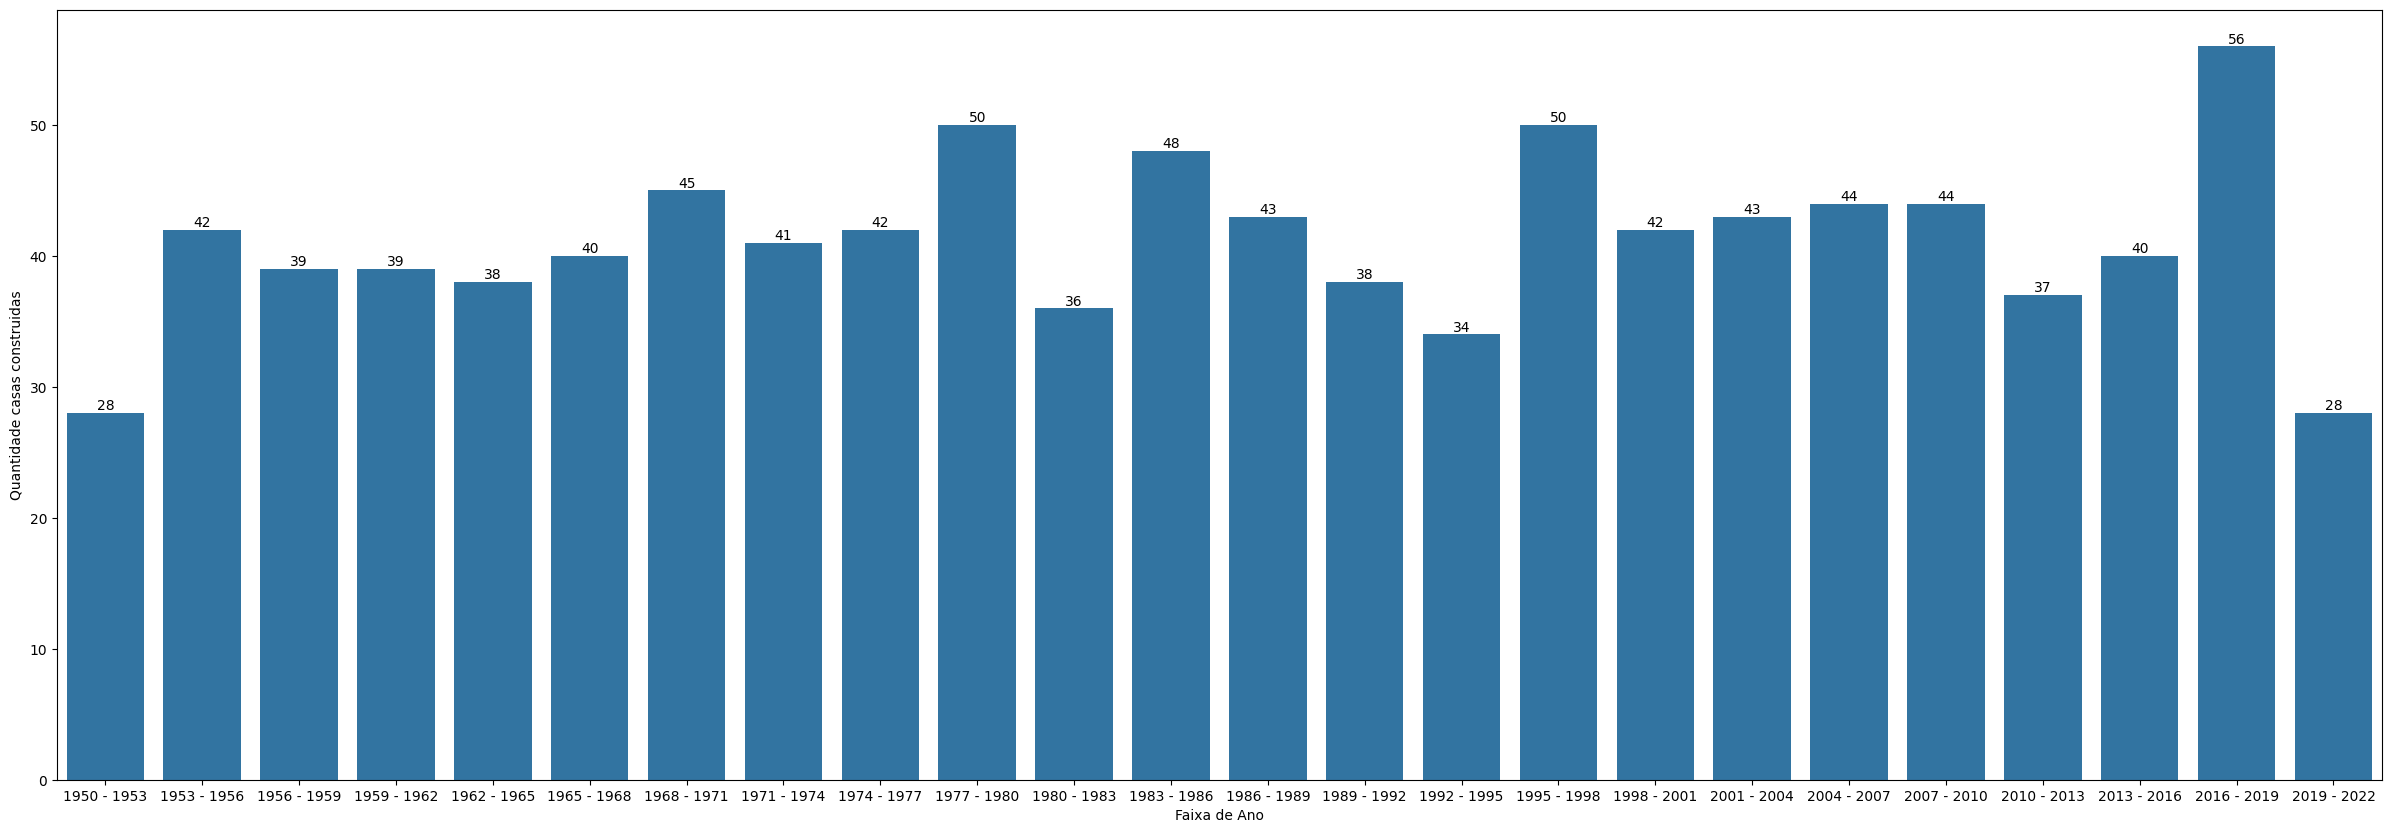

In [39]:
plt.figure(figsize=(30,10))
ax = sns.countplot(data=df, x="Year_Built_Interval")
ax.bar_label(ax.containers[0])
plt.ylabel("Quantidade casas construidas")
plt.xlabel("Faixa de Ano")
plt.show()

Será se o ano de construção da casa influencia no preço da casa?

<Axes: xlabel='House_Price', ylabel='Year_Built'>

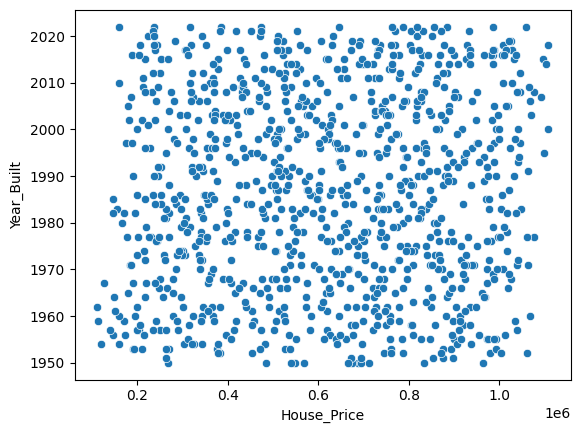

In [40]:
sns.scatterplot(data=df, y="Year_Built", x="House_Price")

<Axes: xlabel='House_Price', ylabel='Age_House'>

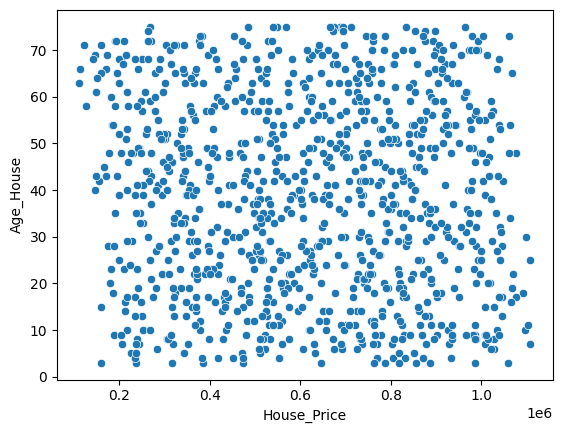

In [41]:
sns.scatterplot(data=df, y="Age_House", x="House_Price") # Aqui usamos a variável que criamos (idade da casa) que representa a mesma informação

In [42]:
# Teste de hipótese
H0 = "Não há relação entre a variável Year_Built e House_Price"
Ha = "Há relação entre a variável Year_Built e House_Price"

In [43]:
# Realizando o teste de hipótese
teste_built = shapiro(df["Year_Built"])
teste_built2 = shapiro(df["Age_House"])
teste_price = shapiro(df["House_Price"])

if teste_built.pvalue < 0.05 and teste_built2.pvalue < 0.05 and teste_price.pvalue < 0.05:
  print("Nossas variáveis não são normais, devemos usar um teste não paramétrico")
else:
  print("Nossas variáveis são normais, vamos usar um teste paramétrico")

Nossas variáveis não são normais, devemos usar um teste não paramétrico


In [44]:
teste_h3 = spearmanr(df["Year_Built"], df["House_Price"])

if teste_h3.pvalue < 0.05:
  print(f"Rejeitamos a Hipótese nula: {H0}")
  print(f"E seguimos com Hipótese alternativa: {Ha}")
else:
  print(f"Não rejeitamos a Hipótese nula: {H0}")

Não rejeitamos a Hipótese nula: Não há relação entre a variável Year_Built e House_Price


Não temos evidencias suficientes para acreditar que o ano em que a casa foi construida influencia no preço da casa

In [45]:
df["Lot_Size"].describe()

,Lot_Size
count,1000.000000
mean,11240.141731
std,5251.316129
min,2047.511555
25%,6740.416503
50%,11368.209705
75%,15873.742252
max,20186.718725


<Axes: xlabel='Lot_Size', ylabel='Count'>

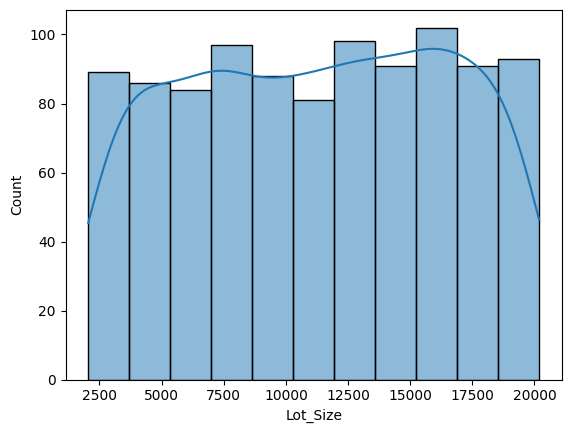

In [46]:
sns.histplot(data=df, x="Lot_Size", kde=True)

Casas construidas em lotes maiores tendem a ter maior metro quadrado?

<Axes: xlabel='Square_Footage', ylabel='Lot_Size'>

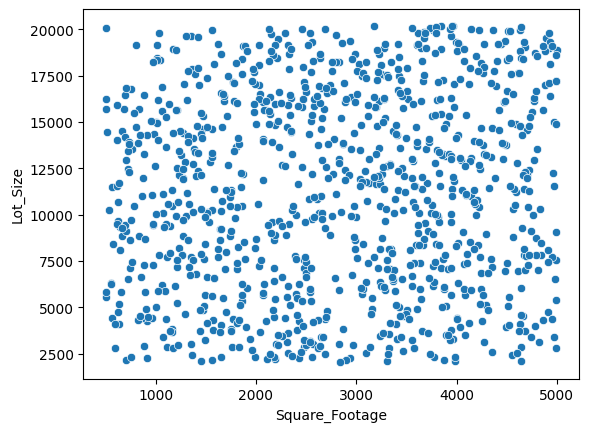

In [47]:
sns.scatterplot(data=df, y="Lot_Size", x="Square_Footage")

As casas de antigamente foram construidas em lotes maiores?

<Axes: xlabel='Lot_Size', ylabel='Year_Built'>

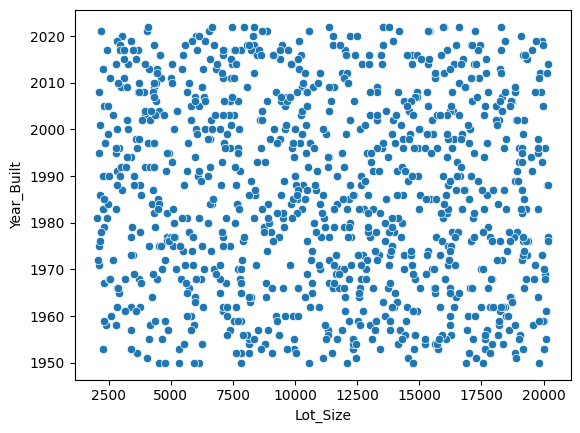

In [48]:
sns.scatterplot(data=df, y="Year_Built", x="Lot_Size")

In [49]:
df["Garage_Size"].describe()

,Garage_Size
count,1000.000000
mean,1.022000
std,0.814973
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


Média de preço da casa pela quantidade de carros que cabem na garagem:

In [50]:
df.groupby("Garage_Size")["House_Price"].agg(["mean","median"]).reset_index()

,Garage_Size,mean,median
0,0,606031.505234,624411.60
1,1,611342.956607,619461.98
2,2,638232.280000,641013.92


Casas com garagens que cabem mais carros são maiores em metros quadrados?

<Axes: xlabel='Square_Footage', ylabel='Garage_Size'>

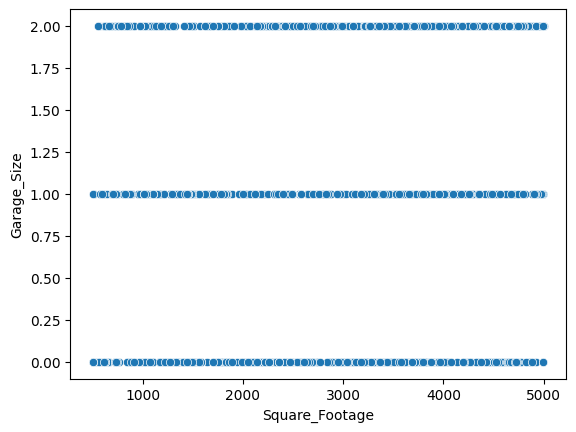

In [51]:
sns.scatterplot(data=df, y="Garage_Size", x="Square_Footage")

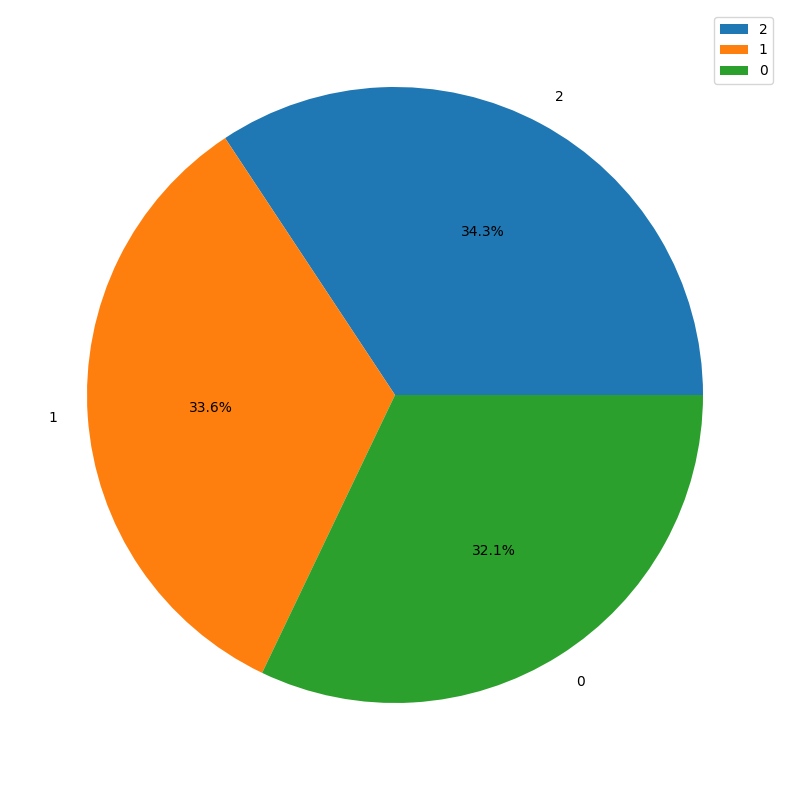

In [52]:
plt.figure(figsize=(30,10))
plt.pie(df["Garage_Size"].value_counts(), labels=df["Garage_Size"].value_counts().index, autopct="%1.1f%%")
plt.legend()
plt.show()

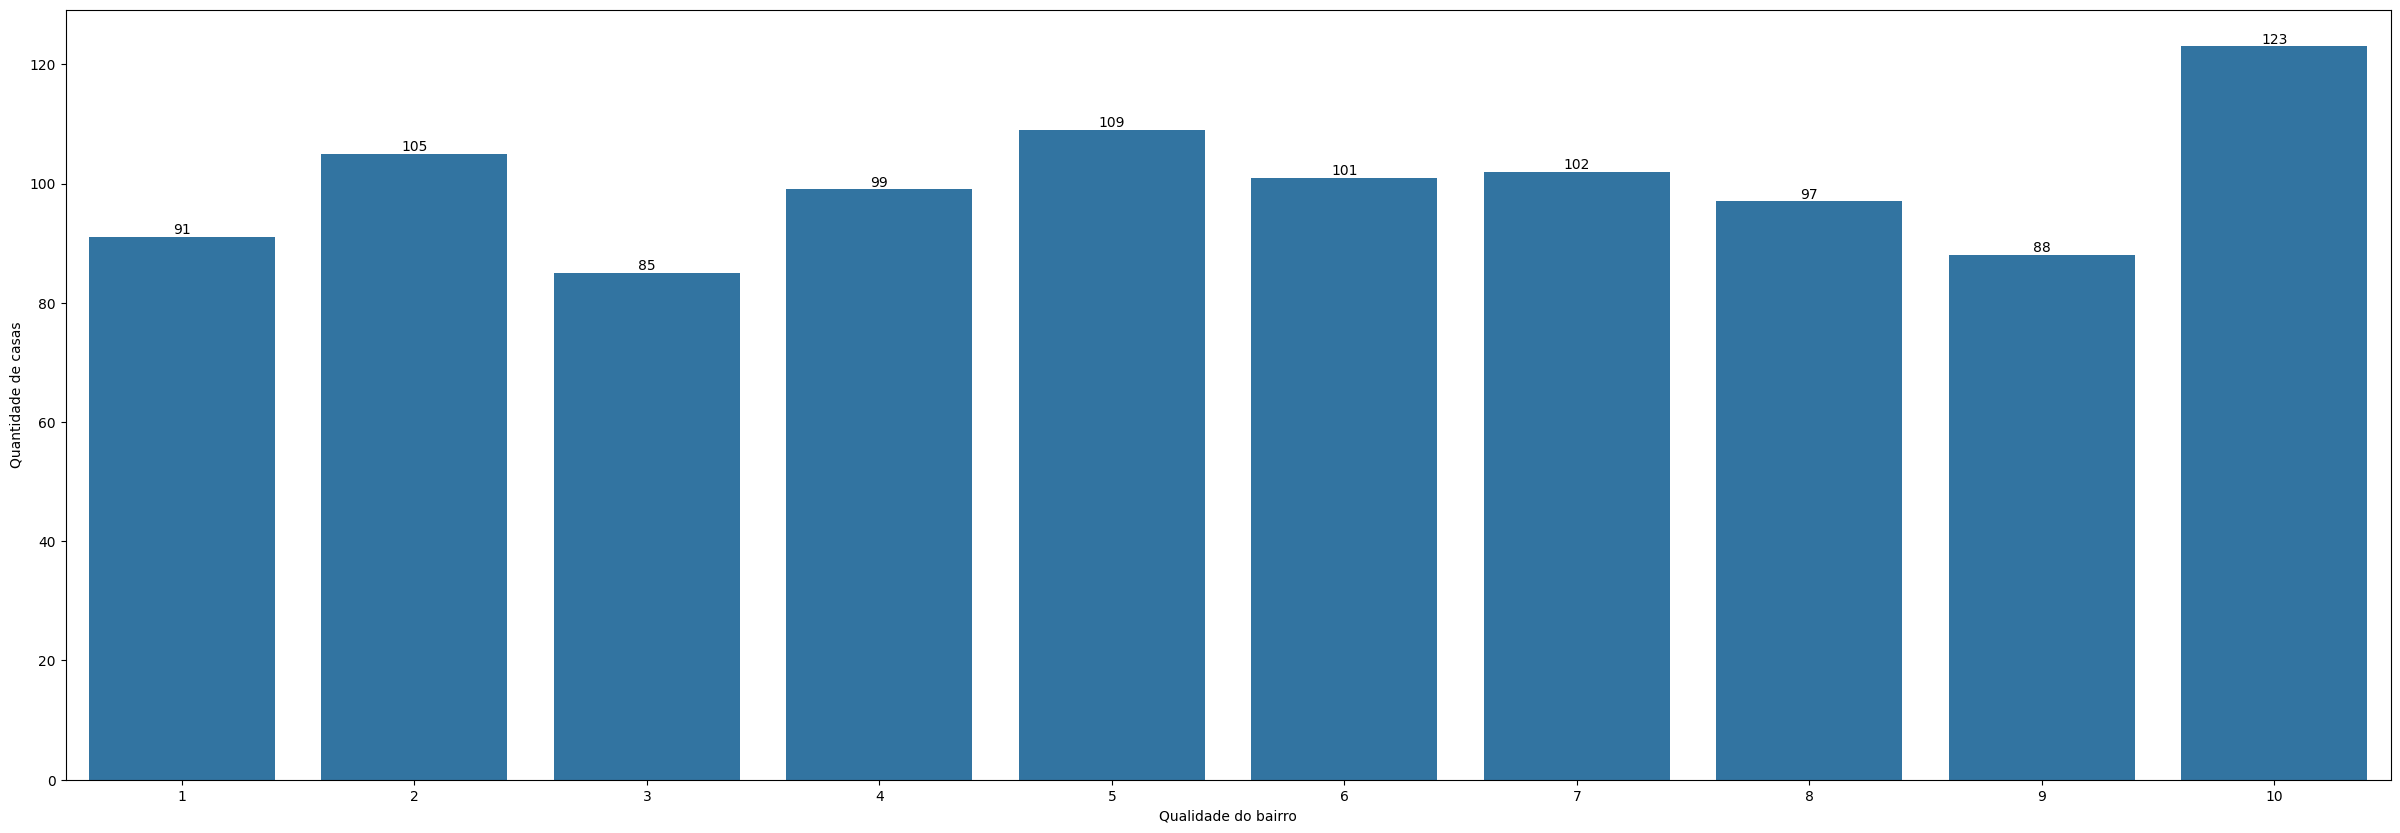

In [53]:
plt.figure(figsize=(30,10))
ax = sns.countplot(data=df, x="Neighborhood_Quality")
ax.bar_label(ax.containers[0])
plt.ylabel("Quantidade de casas")
plt.xlabel("Qualidade do bairro")
plt.show()

Será se a qualidade do bairo influencia no preço da casa?

<Axes: xlabel='House_Price', ylabel='Neighborhood_Quality'>

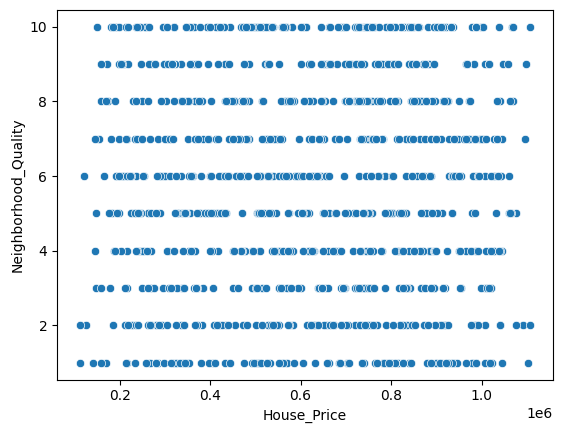

In [54]:
sns.scatterplot(data=df, y="Neighborhood_Quality", x="House_Price")

Média de preço das casas com suas classificações de bairro:

In [55]:
df.groupby("Neighborhood_Quality")["House_Price"].agg(["mean","median"]).reset_index()

,Neighborhood_Quality,mean,median
0,1,632968.700220,663904.99
1,2,613066.045429,635097.40
2,3,625680.912824,656223.16
3,4,629867.221515,626454.28
4,5,595239.564128,602549.28
5,6,593803.859901,574912.77
6,7,648856.343431,664199.61
7,8,630746.108969,654466.95
8,9,617873.065000,666351.52
9,10,607767.056667,581948.16


Verificando possiveís outliers:

<Axes: >

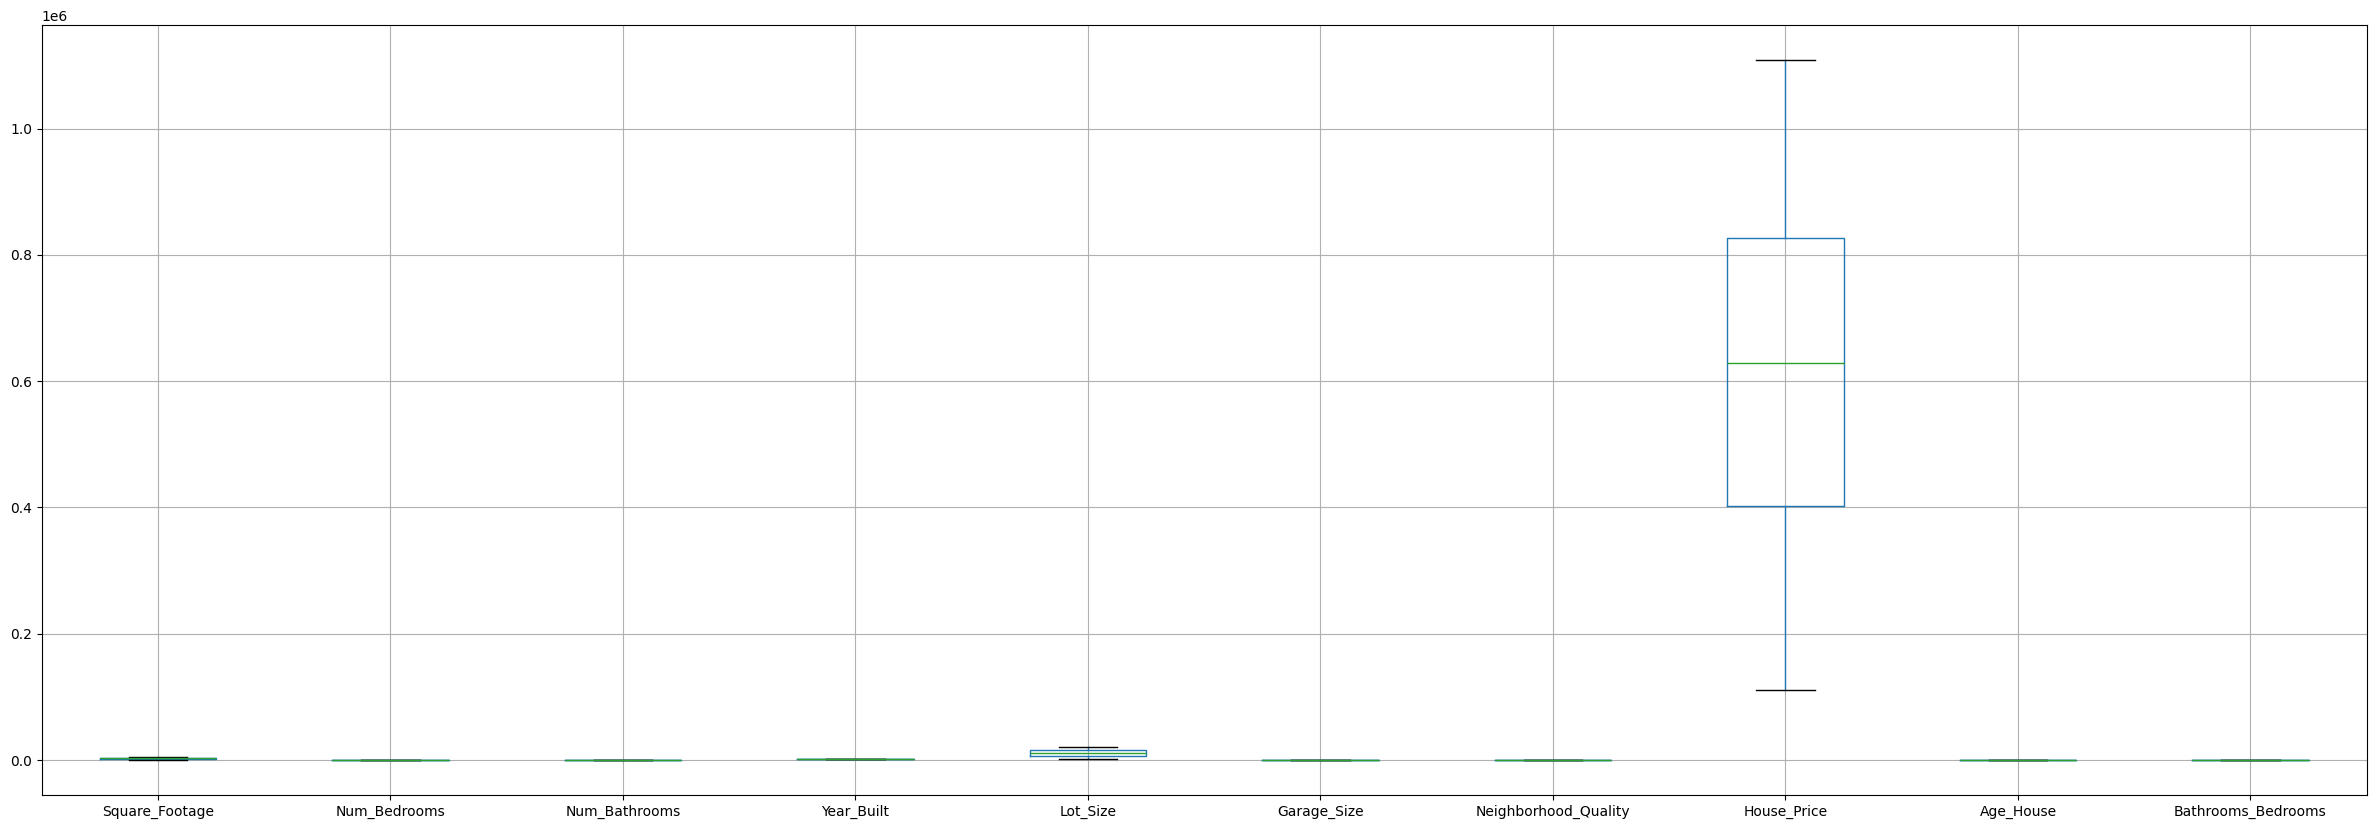

In [56]:
df.boxplot(figsize=(30,10))

Podemos observar que não temos pontos extremos, porém temos um detalhe importante nossos dados estão em escalas distintas, em nosso modelo podemos usar alguma técnica de transformação dos dados (normalização ou padronização)

Testando se todas nossas variáveis são normais ou não normais

In [57]:
for coluna in df.columns:
  teste = shapiro(df[coluna])
  if teste.pvalue < 0.05:
    print(f"A variável {coluna} não é normal")
  else:
    print(f"A variável {coluna} é normal")

A variável Square_Footage não é normal
A variável Num_Bedrooms não é normal
A variável Num_Bathrooms não é normal
A variável Year_Built não é normal
A variável Lot_Size não é normal
A variável Garage_Size não é normal
A variável Neighborhood_Quality não é normal
A variável House_Price não é normal
A variável Age_House não é normal
A variável Bathrooms_Bedrooms não é normal
A variável Year_Built_Interval é normal


Nenhuma das nossas variáveis são normais, então vamos usar um teste de correlação não paramétrico (spearmanr)

Mapa de correlação:

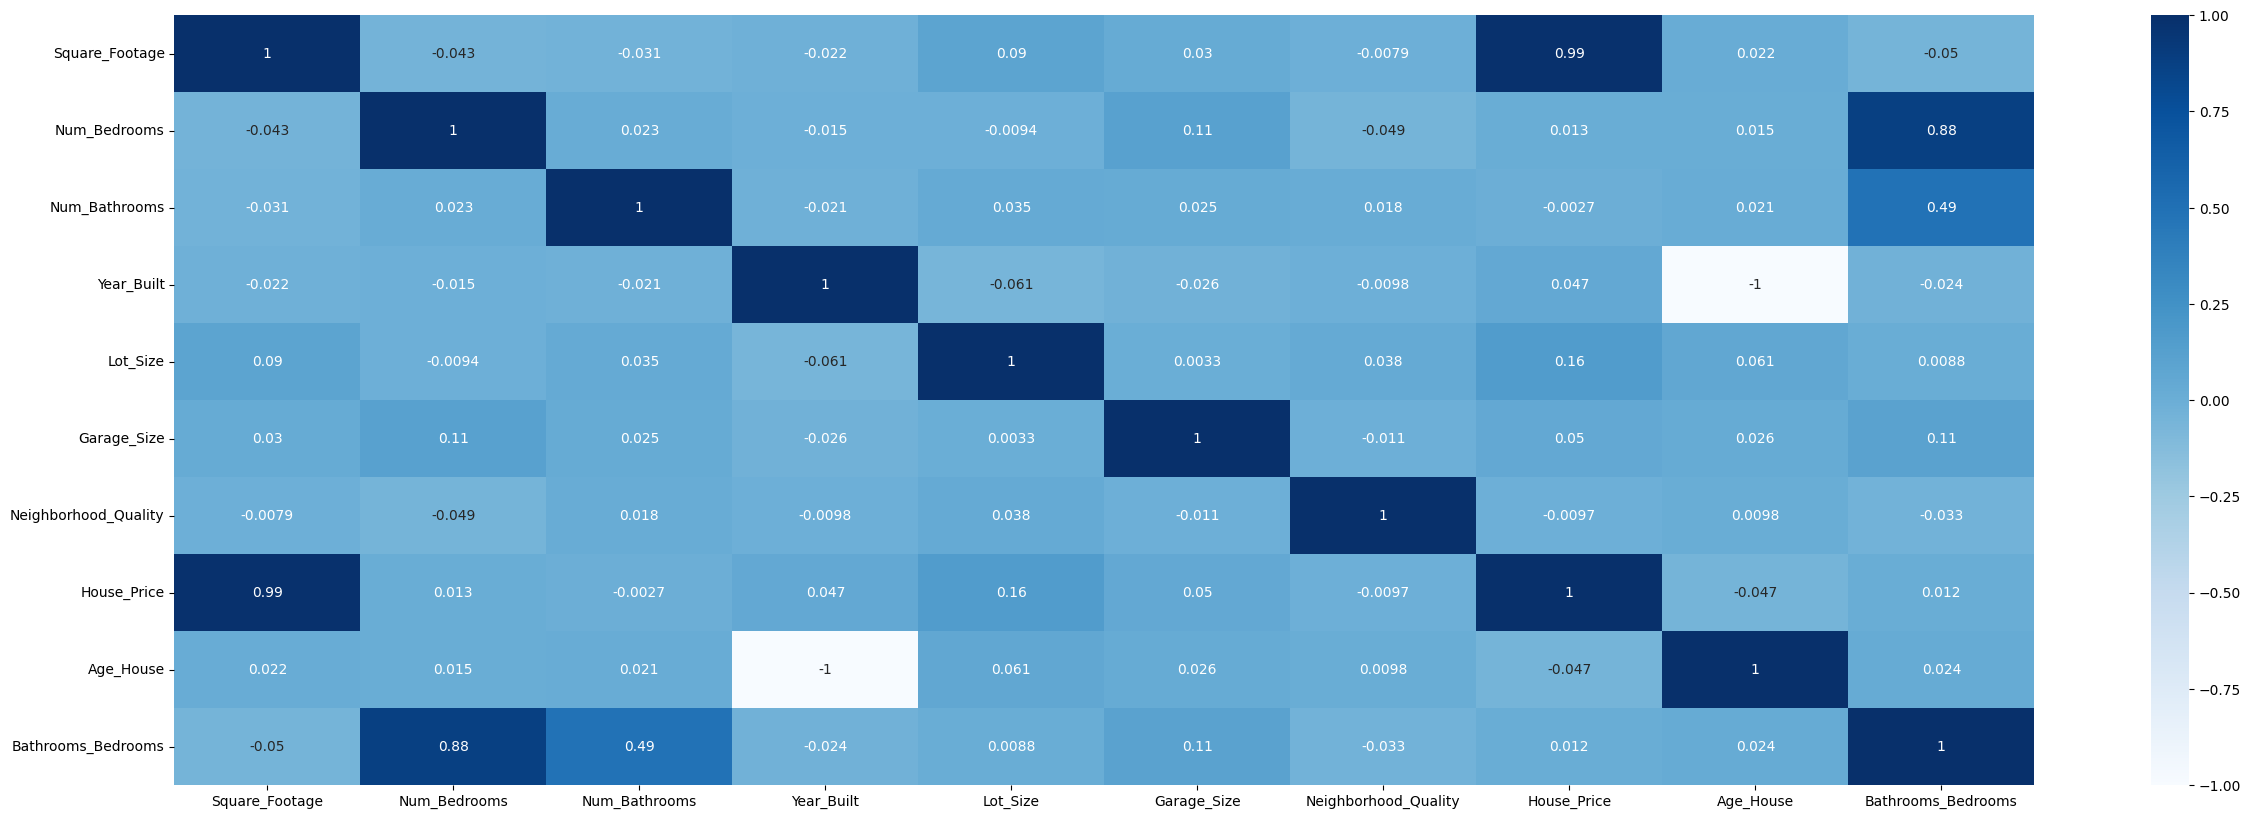

In [58]:
plt.figure(figsize=(30,10))
coor = df.drop(columns="Year_Built_Interval").corr(method="spearman")
sns.heatmap(coor, annot=True, cmap="Blues")
plt.show()

Year_Built e Age_House estão fortemente correlacionadas pois representam a mesma informação

# Modelo Linear Regression

Vamos excluir a variável "Year_Built" dos dados de treinamento, pois ela representa a mesma informação de "Age_House" e pode acontecer no modelo um caso de multicolinearidade duas variáveis independentes fortemente correlacionadas

In [59]:
colunas = df.drop(columns=["Year_Built_Interval","Year_Built"]).columns

In [60]:
# Dados da maneira que já está
df_reg = df.drop(columns=["Year_Built_Interval","Year_Built"])

In [61]:
colunas # Variáveis que vamos usar ao longo do modelo

Index(['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Lot_Size',
       'Garage_Size', 'Neighborhood_Quality', 'House_Price', 'Age_House',
       'Bathrooms_Bedrooms'],
      dtype='object')

Certo para afins de treino e teste, vamos usar os dados em 3 escalas (dados da maneira que já está, dados normalizados e dados padronizados)

In [62]:
# Normalizando (deixa a escala dos dados entre 0 e 1)
scaler_norm_X = MinMaxScaler()
scaler_norm_Y = MinMaxScaler()
X_norm = pd.DataFrame(scaler_norm_X.fit_transform(df.drop(columns=["Year_Built_Interval","House_Price","Year_Built"])))
Y_norm = pd.DataFrame(scaler_norm_Y.fit_transform(df[["House_Price"]]))

In [63]:
# Renomeando as variáveis
X_norm.columns = colunas.drop("House_Price")
Y_norm.rename(columns={0:"House_Price"},inplace=True)

<Axes: >

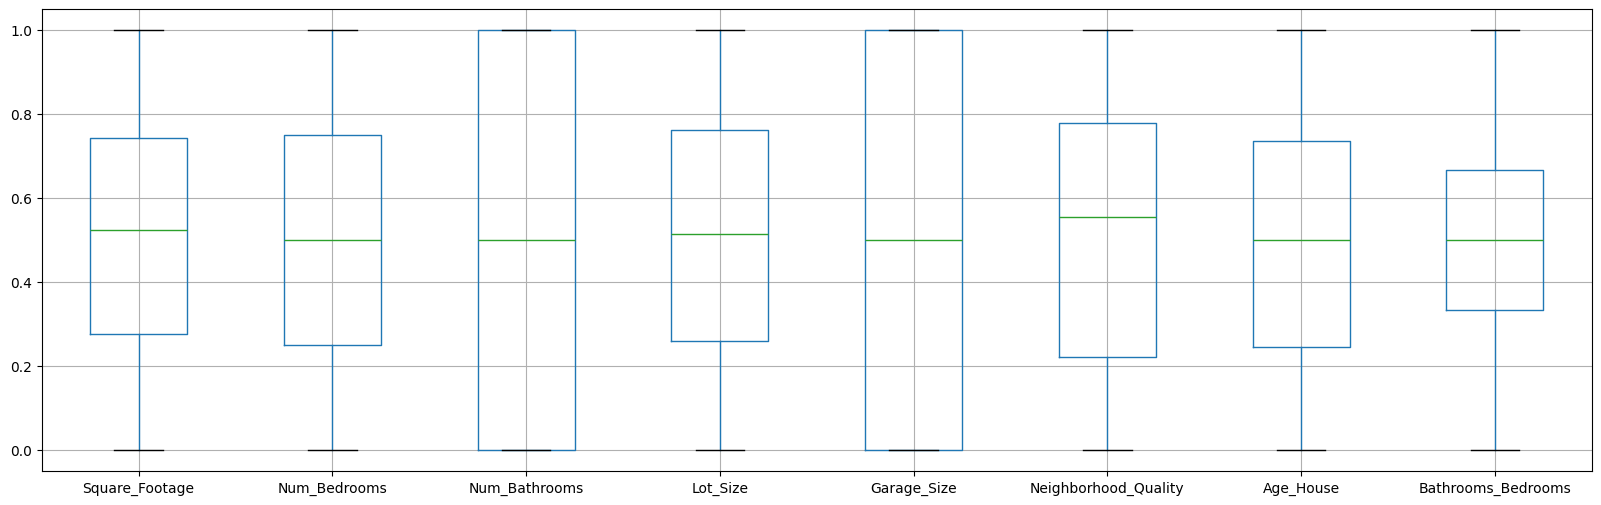

In [64]:
X_norm.boxplot(figsize=(20,6)) # Dados normalizados das variáves independentes

<Axes: >

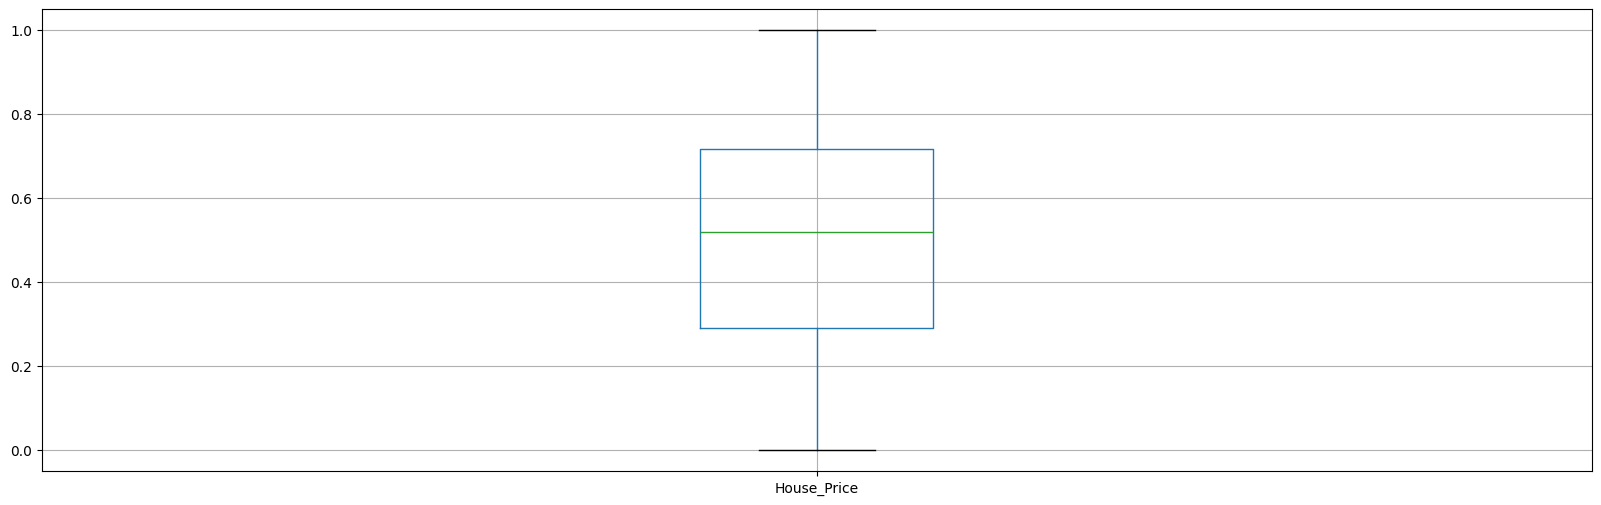

In [65]:
Y_norm.boxplot(figsize=(20,6)) # Dados normalizados da variável dependente

In [66]:
# Padronizando (deixa a escala dos dados com média 0 e desvio padrão 1)
scaler_padr_X = StandardScaler()
scaler_padr_Y = StandardScaler()
X_padr = pd.DataFrame(scaler_padr_X.fit_transform(df.drop(columns=["Year_Built_Interval","House_Price","Year_Built"])))
Y_padr = pd.DataFrame(scaler_padr_Y.fit_transform(df[["House_Price"]]))

In [67]:
# Renomeando as variáveis
X_padr.columns = colunas.drop("House_Price")
Y_padr.rename(columns={0:"House_Price"},inplace=True)

<Axes: >

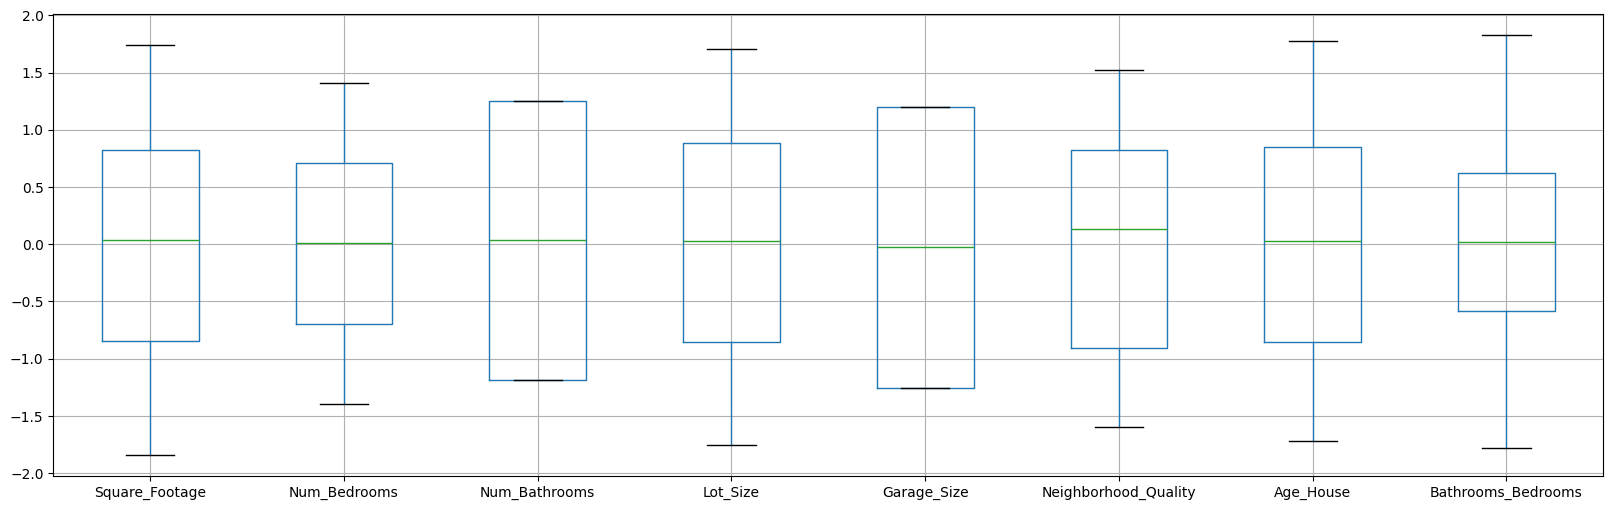

In [68]:
X_padr.boxplot(figsize=(20,6)) # Dados padronizados das variáveis independentes

<Axes: >

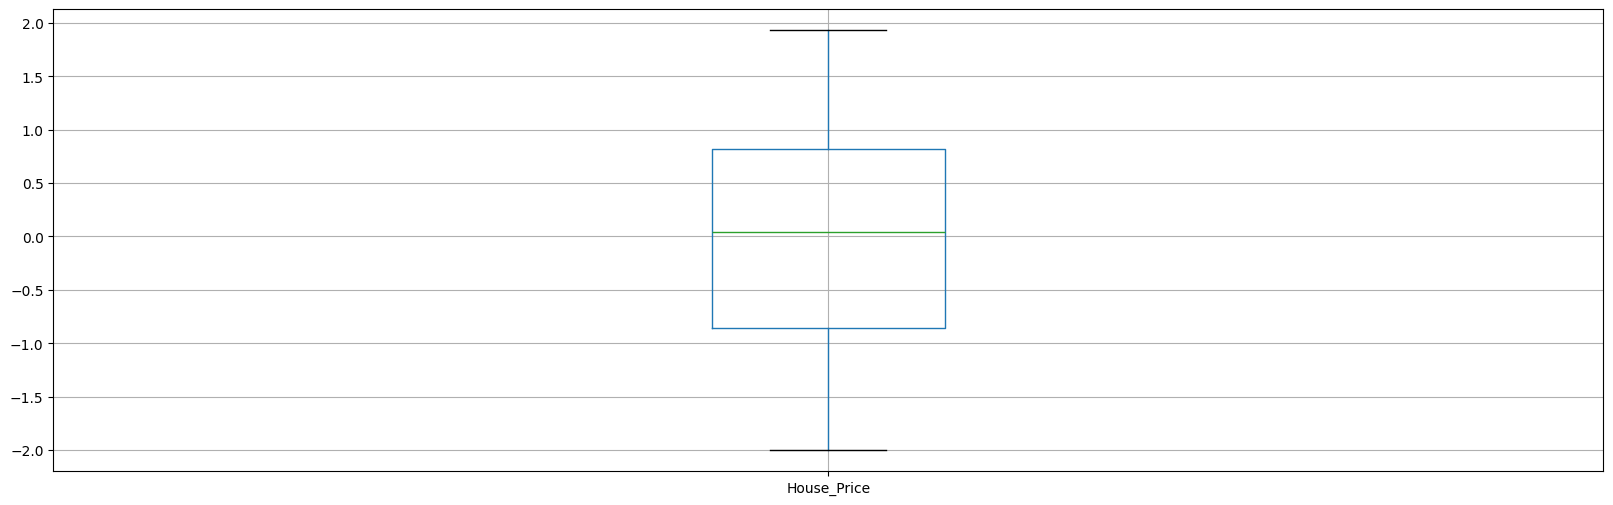

In [69]:
Y_padr.boxplot(figsize=(20,6)) # Dados padronizados da variável dependente

Realizando o treinamento com dados regulares da maneira que já está:

In [70]:
seed = 42 # Semente para sempre pegar os mesmos dados
size = 0.20 # Vamos separar os dados de treino com 80% e 20% de teste

In [71]:
X_reg = df_reg.drop(columns="House_Price") # Variáveis independentes
Y_reg = df_reg["House_Price"] # Variável dependente (target)

In [72]:
X_treino_reg, X_teste_reg, Y_treino_reg, Y_teste_reg = train_test_split(X_reg, Y_reg, test_size=size, random_state=seed) # Separando os dados
X_const_treino_reg = sm.add_constant(X_treino_reg) # Constante para o modelo

In [73]:
modelo_reg = LinearRegression() # Criando o modelo
modelo_reg.fit(X_treino_reg, Y_treino_reg) # Treinando o modelo

LinearRegression()

In [74]:
modelo_reg.coef_ # Coeficientes do modelo

array([ 1.99513245e+02,  4.08065791e+03,  2.06388846e+03,  3.67903717e+00,
        5.14614841e+03,  1.15068600e+02, -9.93537171e+02,  6.14454637e+03])

In [75]:
modelo_reg.intercept_ # Intercepto do modelo

np.float64(1345.3513534032973)

In [76]:
modelo_reg.score(X_treino_reg, Y_treino_reg) # Coeficiente de determinação do modelo nos dados de treino

0.9985375946610447

In [77]:
modelo_reg.score(X_teste_reg, Y_teste_reg) # Coeficiente de determinação do modelo nos dados de teste

0.9984263635672083

Coeficiente de determinação é uma medida do poder explicativo do nosso modelo variando entre 0 e 1, ele indica pra gente o com forte as variáveis independentes explicam a variável dependente (Medida da explicabilidade do nosso modelo)

Usando os mesmos dados regulares porém com outra biblioteca que possui um algoritmo de regressão:

In [78]:
modelo_sm_reg = sm.OLS(Y_treino_reg, X_const_treino_reg) # Criando o modelo
modelo_sm_reg = modelo_sm_reg.fit() # Treinando o modelo

In [79]:
print(modelo_sm_reg.summary()) # Exibindo o resumo do modelo

                            OLS Regression Results                            
Dep. Variable:            House_Price   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.725e+04
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        11:55:46   Log-Likelihood:                -8478.0
No. Observations:                 800   AIC:                         1.697e+04
Df Residuals:                     792   BIC:                         1.701e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1345.3514 

Podemos ver nosso coeficiente de determinação ou poder explicativo do nosso modelo está no melhor cénario possivel e ainda podemos ver que nosso modelo é significativamente estatistico ou seja nossas variáveis independentes impactam e são influente em nossa variável dependente.

Antes de proseguirmos vamos excluir duas variáveis do nosso modelo, uma que não apresentou signicância com um p-valor maior que 0.05 e outra que pode ser representada com outras variáveis: Neighborhood_Quality e Bathrooms_Bedrooms.

In [80]:
# Removendo as variáveis
df_reg = df_reg.drop(columns=["Neighborhood_Quality","Bathrooms_Bedrooms"])
X_norm = X_norm.drop(columns=["Neighborhood_Quality","Bathrooms_Bedrooms"])
X_padr = X_padr.drop(columns=["Neighborhood_Quality","Bathrooms_Bedrooms"])

In [81]:
X_reg2 = df_reg.drop(columns="House_Price") # Variáveis independentes após remoção de duas delas

In [82]:
X_treino_reg2, X_teste_reg2, Y_treino_reg2, Y_teste_reg2 = train_test_split(X_reg2, Y_reg, test_size=size, random_state=seed) # Separando os dados
X_const_treino_reg2 = sm.add_constant(X_treino_reg2) # Constante para o modelo

In [83]:
modelo_reg2 = LinearRegression() # Criando o modelo
modelo_reg2.fit(X_treino_reg2, Y_treino_reg2) # Treinando o modelo

LinearRegression()

In [84]:
modelo_reg2.coef_ # Coeficientes do modelo

array([ 1.99509336e+02,  1.02171612e+04,  8.22575265e+03,  3.68142530e+00,
        5.15138536e+03, -9.93484467e+02])

In [85]:
modelo_reg2.score(X_treino_reg2, Y_treino_reg2) # Coeficiente de determinação do modelo nos dados de treino

0.9985358512444772

In [86]:
modelo_reg2.score(X_teste_reg2, Y_teste_reg2) # Coeficiente de determinação do modelo nos dados de teste

0.9984298271920117

In [87]:
modelo_sm_reg2 = sm.OLS(Y_treino_reg2, X_const_treino_reg2) # Criando o modelo
modelo_sm_reg2 = modelo_sm_reg2.fit() # Treinando o modelo

In [88]:
print(modelo_sm_reg2.summary()) # Exibindo o resumo do modelo

                            OLS Regression Results                            
Dep. Variable:            House_Price   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 9.014e+04
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        11:55:46   Log-Likelihood:                -8478.5
No. Observations:                 800   AIC:                         1.697e+04
Df Residuals:                     793   BIC:                         1.700e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1955.9337   1655.561      1.

Avaliando o modelo com dados regulares:

In [89]:
X_const_teste_reg2 = sm.add_constant(X_teste_reg2) # Constante para o modelo
pred_modelo_reg2 = modelo_sm_reg2.predict(X_const_teste_reg2) # Prevendo os dados de teste

In [90]:
pred_modelo_sm_reg2 = modelo_sm_reg2.predict(X_const_teste_reg2) # Prevendo os dados de teste

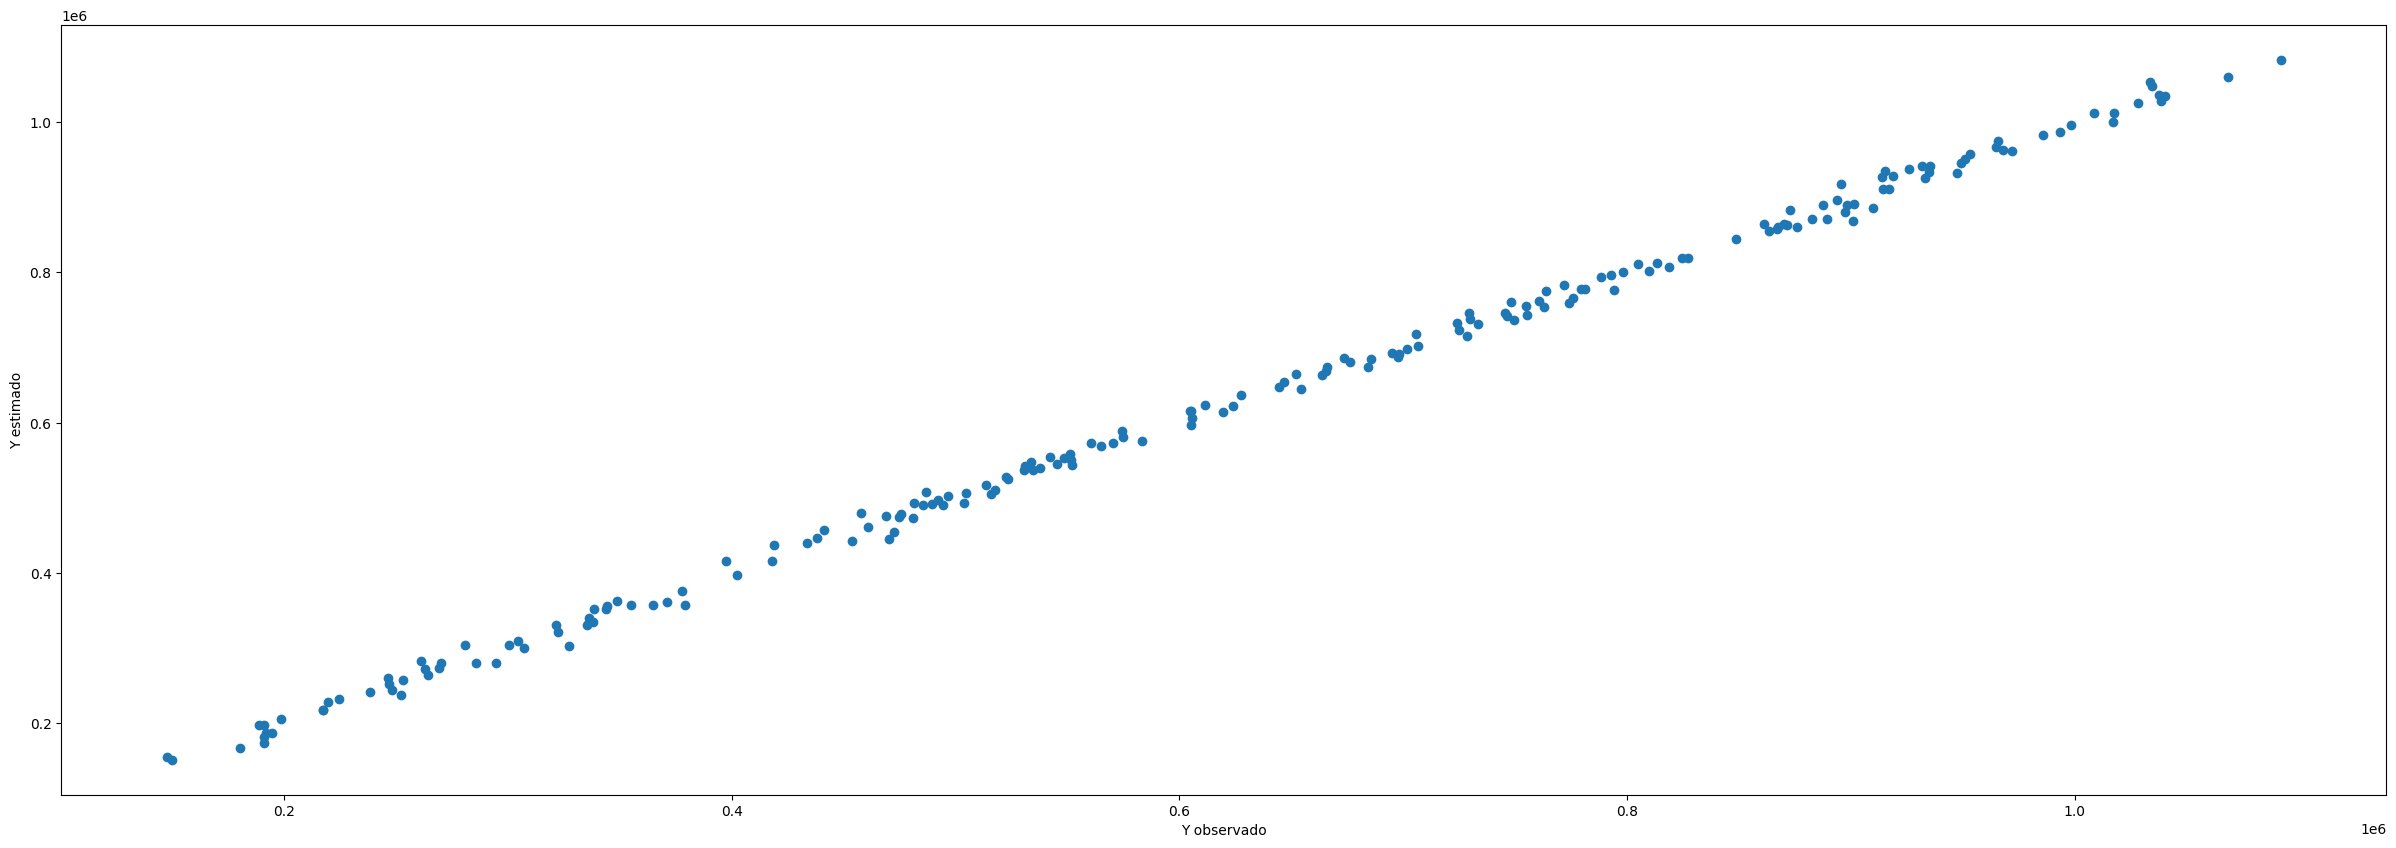

In [91]:
# Gráfico de dispersão dos Y observado e Y estimado
plt.figure(figsize=(30,10))
plt.scatter(Y_teste_reg2, pred_modelo_reg2)
plt.xlabel("Y observado")
plt.ylabel("Y estimado")
plt.show()

In [92]:
# Erro médio do modelo
round(mean_squared_error(Y_teste_reg2, pred_modelo_reg2))

101211545

In [93]:
# Erro médio do modelo na mesma escala da variável target
round(np.sqrt(mean_squared_error(Y_teste_reg2, pred_modelo_reg2)))

10060

In [94]:
# Residuos do modelo
df_modelo_reg2 = pd.DataFrame()
df_modelo_reg2["Y observado"] = Y_teste_reg2
df_modelo_reg2["Y estimado"] = pred_modelo_reg2
df_modelo_reg2["Residuos"] = df_modelo_reg2["Y observado"] - df_modelo_reg2["Y estimado"]

Text(0.5, 0, 'Y estimado')

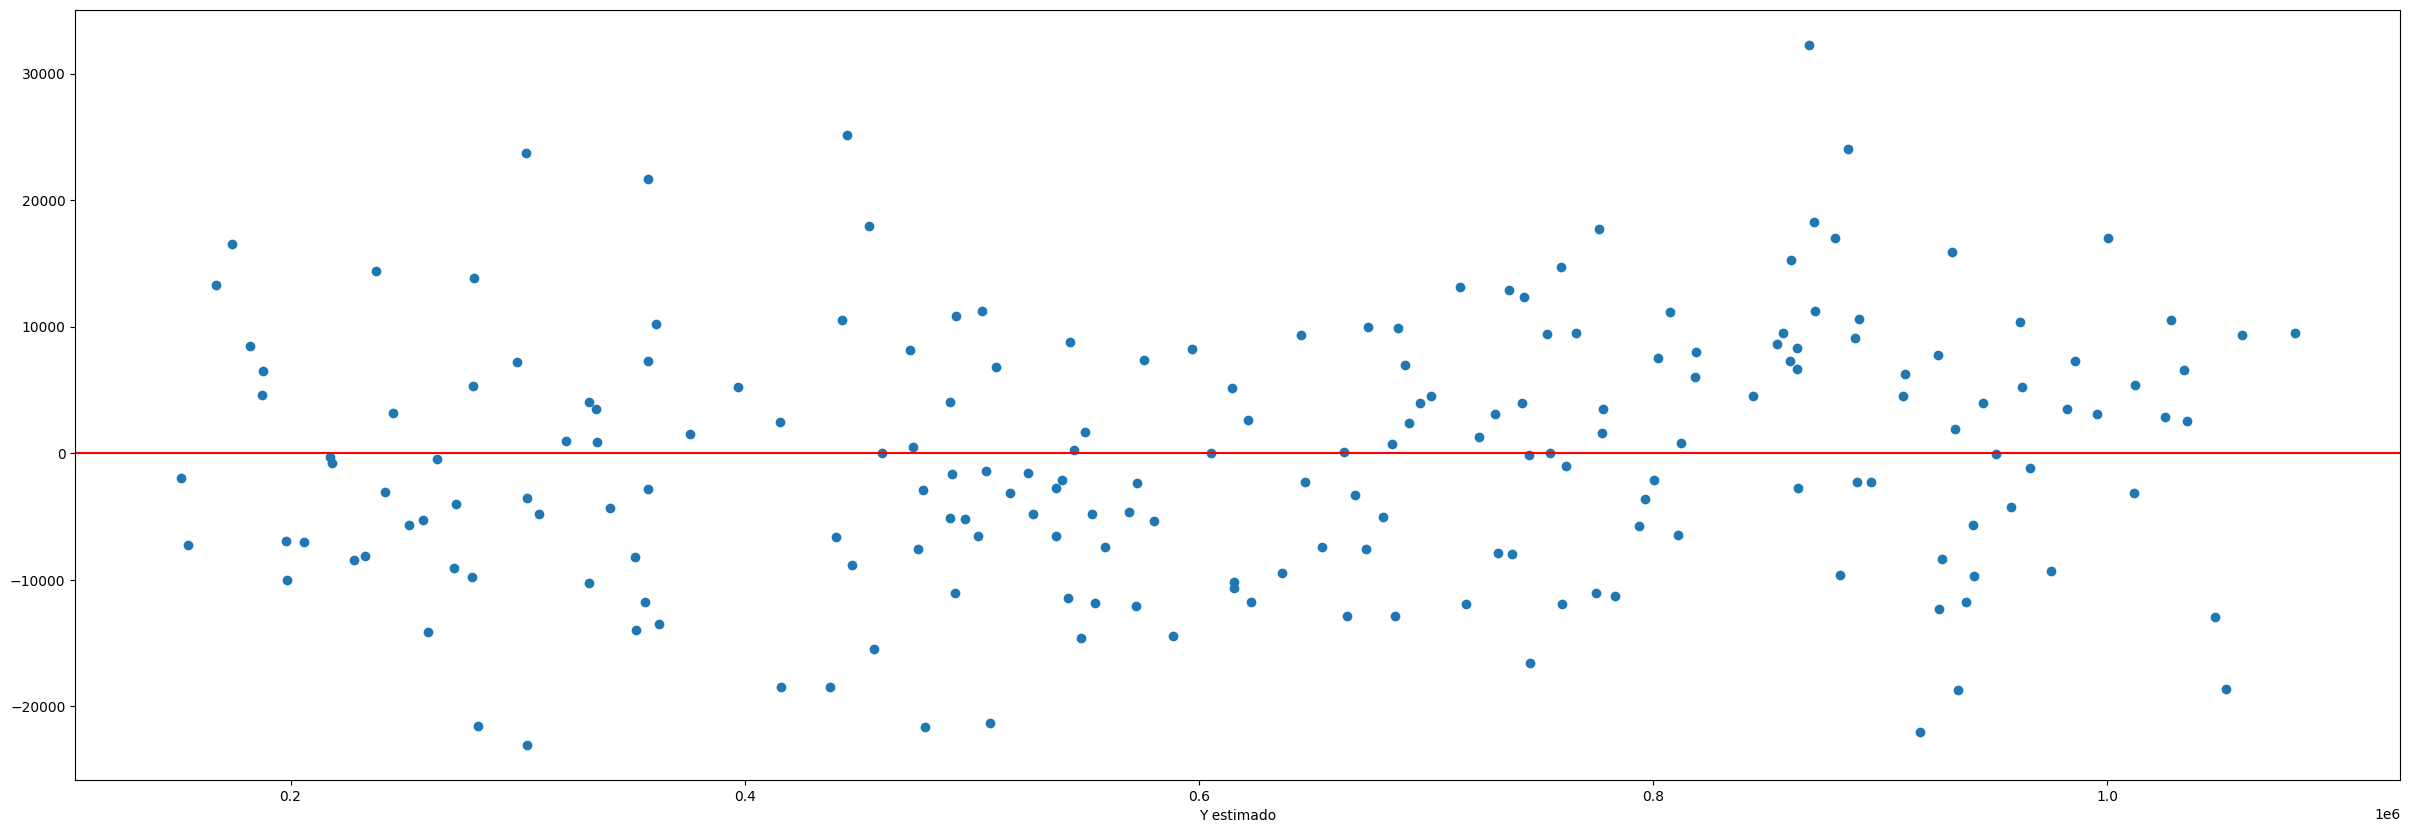

In [95]:
# Avaliação dos residuos
plt.figure(figsize=(30,10))
plt.scatter(df_modelo_reg2["Y estimado"], df_modelo_reg2["Residuos"])
plt.axhline(y=0, color="red")
plt.xlabel("Y estimado")

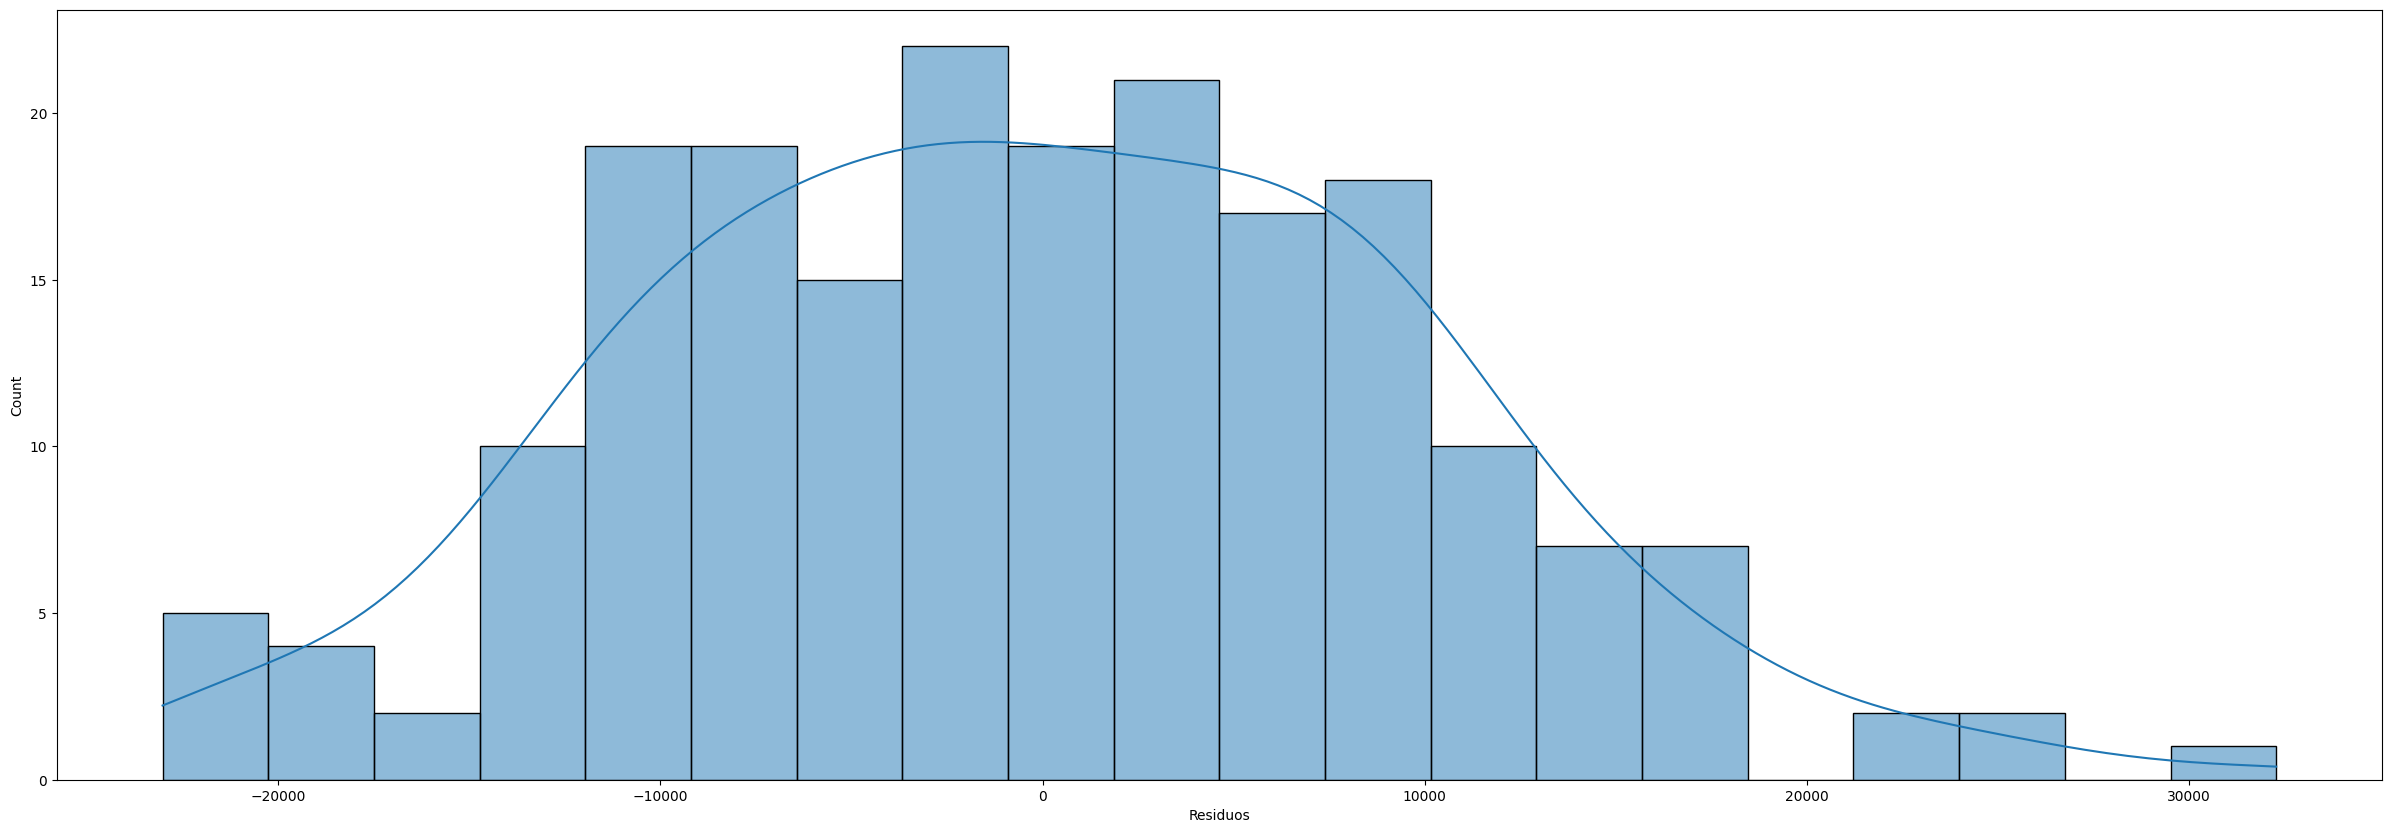

In [96]:
# Distribuição dos residuos
plt.figure(figsize=(30,10))
sns.histplot(df_modelo_reg2["Residuos"], bins=20,kde=True)
plt.show()

Modelo com dados padronizados

In [97]:
# Dados padronizados é onde todas as variáveis tem média igual a 0 e desvio padrão igual a 1
# z = (x - u) / s

In [98]:
X_padr_modelo = X_padr # Variáveis independentes
Y_padr_modelo = Y_padr # Variável dependente (target)

In [99]:
X_treino_padr, X_teste_padr, Y_treino_padr, Y_teste_padr = train_test_split(X_padr_modelo, Y_padr_modelo, test_size=size, random_state=seed) # Separando os dados
X_const_padr = sm.add_constant(X_treino_padr) # Constante para o modelo

In [100]:
# Tamanho dados de treino
X_treino_padr.shape, Y_treino_padr.shape

((800, 6), (800, 1))

In [101]:
# Tamanho dados de teste
X_teste_padr.shape, Y_teste_padr.shape

((200, 6), (200, 1))

In [102]:
# Criando os modelos
modelo_padr = LinearRegression() # Sklearn
modelo_sm_padr = sm.OLS(Y_treino_padr, X_const_padr) # Stats Models

In [103]:
# Treinando os modelo
modelo_padr.fit(X_treino_padr, Y_treino_padr)
modelo_sm_padr = modelo_sm_padr.fit()

In [104]:
# Avaliando o modelo do Sklearn
modelo_padr.score(X_treino_padr, Y_treino_padr) # Coeficiente de determinação nos dados de treino

0.9985358512444772

In [105]:
modelo_padr.score(X_teste_padr, Y_teste_padr) # Coeficiente de determinação nos dados de teste

0.9984298271920121

In [106]:
print(modelo_sm_padr.summary()) # Exibindo o resumo do modelo do stats models

                            OLS Regression Results                            
Dep. Variable:            House_Price   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 9.014e+04
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        11:55:49   Log-Likelihood:                 1475.8
No. Observations:                 800   AIC:                            -2938.
Df Residuals:                     793   BIC:                            -2905.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           8.519e-05      0.001      0.

In [107]:
# Realizando as previsões
X_const_teste_padr = sm.add_constant(X_teste_padr) # Constante para o modelo
pred_modelo_sm_padr = modelo_sm_padr.predict(X_const_teste_padr)
pred_modelo_padr = modelo_padr.predict(X_teste_padr)

In [108]:
# Revertendo a transformação da padronização
pred_trans_padr = scaler_padr_Y.inverse_transform(pred_modelo_padr)

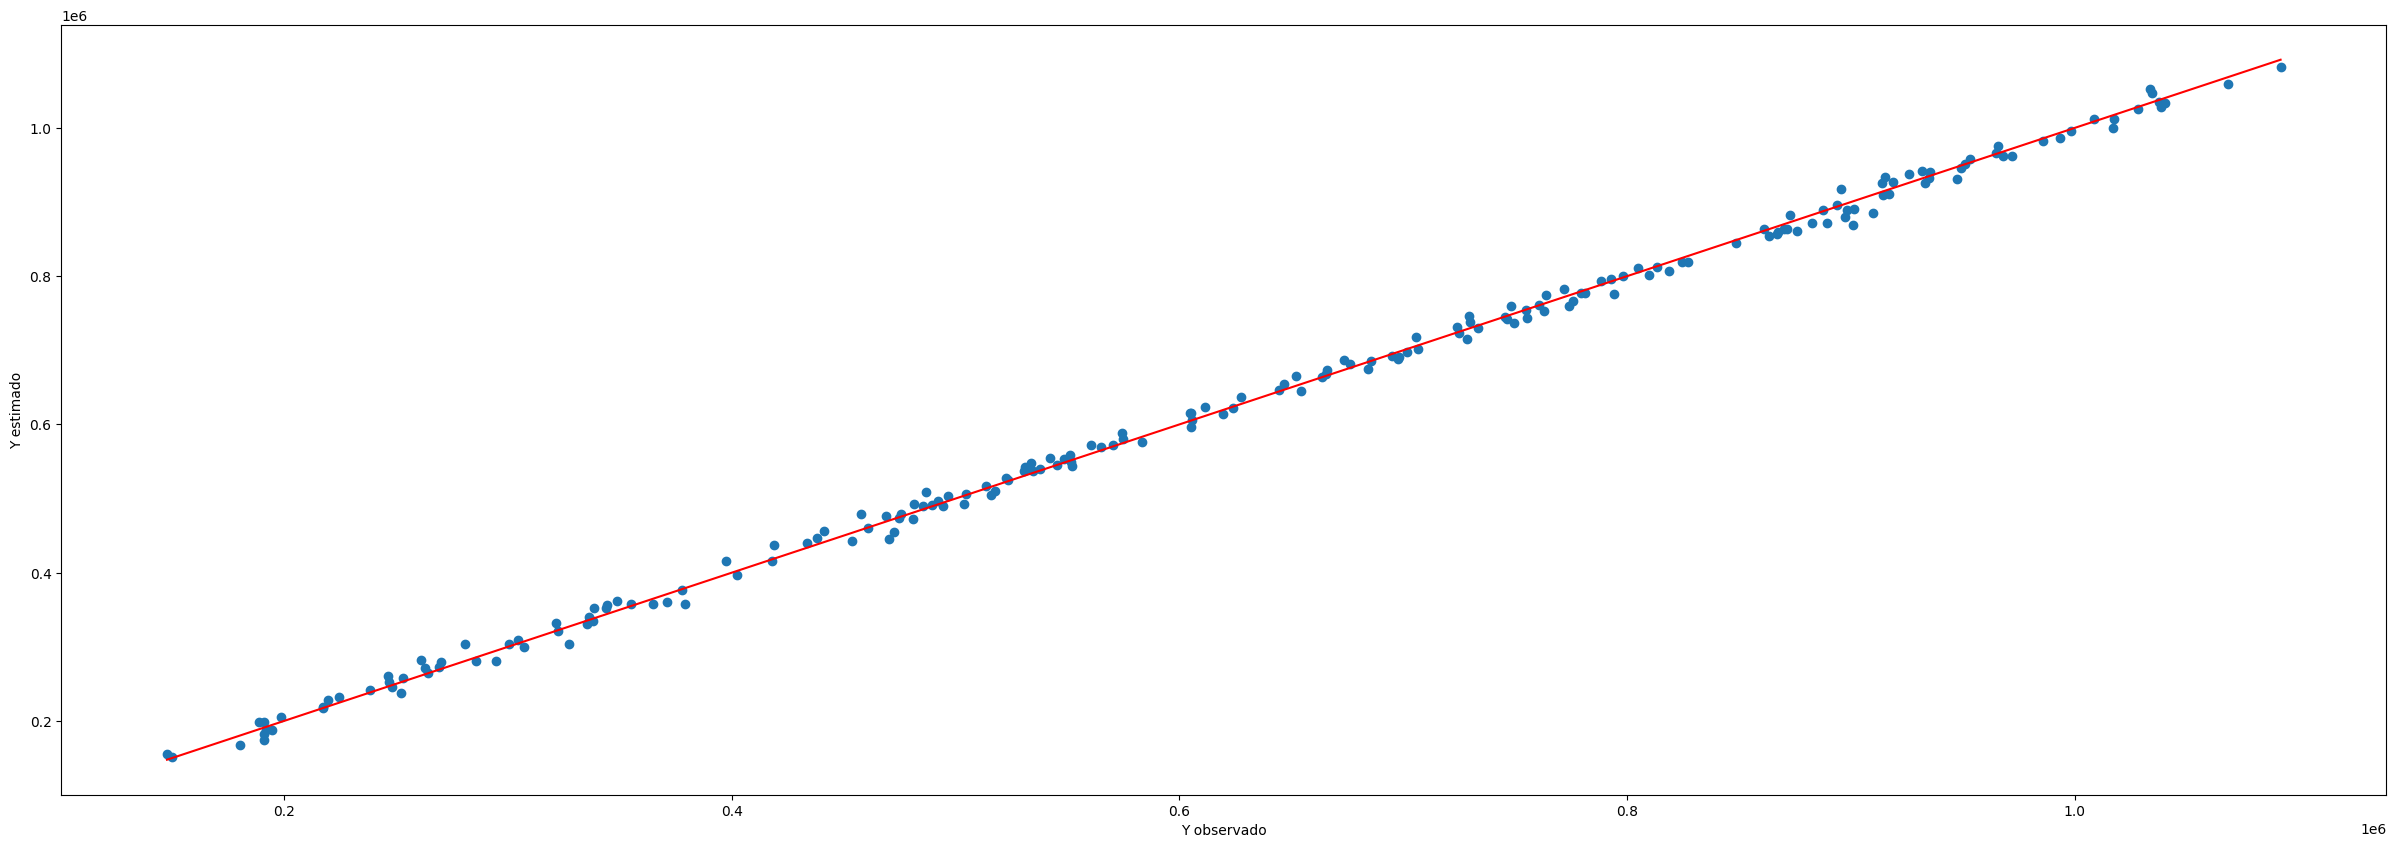

In [109]:
# Avaliando o Y observado com o Y estimado
plt.figure(figsize=(30,10))
plt.scatter(Y_teste_reg2, pred_trans_padr)
plt.plot([Y_teste_reg2.min(), Y_teste_reg2.max()], [Y_teste_reg2.min(), Y_teste_reg2.max()], color="red")
plt.xlabel("Y observado")
plt.ylabel("Y estimado")
plt.show()

In [110]:
# Erro médido quadrático (MSE)
round(mean_squared_error(Y_teste_reg2, pred_trans_padr))

101211545

In [111]:
# Erro médio absoluto (MAE)
round(mean_absolute_error(Y_teste_reg2, pred_trans_padr))

8165

In [112]:
# Raiz do erro médio (mesma escala da variável target) (RSME)
round(np.sqrt(mean_squared_error(Y_teste_reg2, pred_trans_padr)))

10060

In [113]:
# Avaliando os residuos
df_modelo_padr = pd.DataFrame()
df_modelo_padr["Y observado"] = Y_teste_reg2
df_modelo_padr["Y estimado"] = pred_trans_padr
df_modelo_padr["Residuos"] = df_modelo_padr["Y observado"] - df_modelo_padr["Y estimado"]

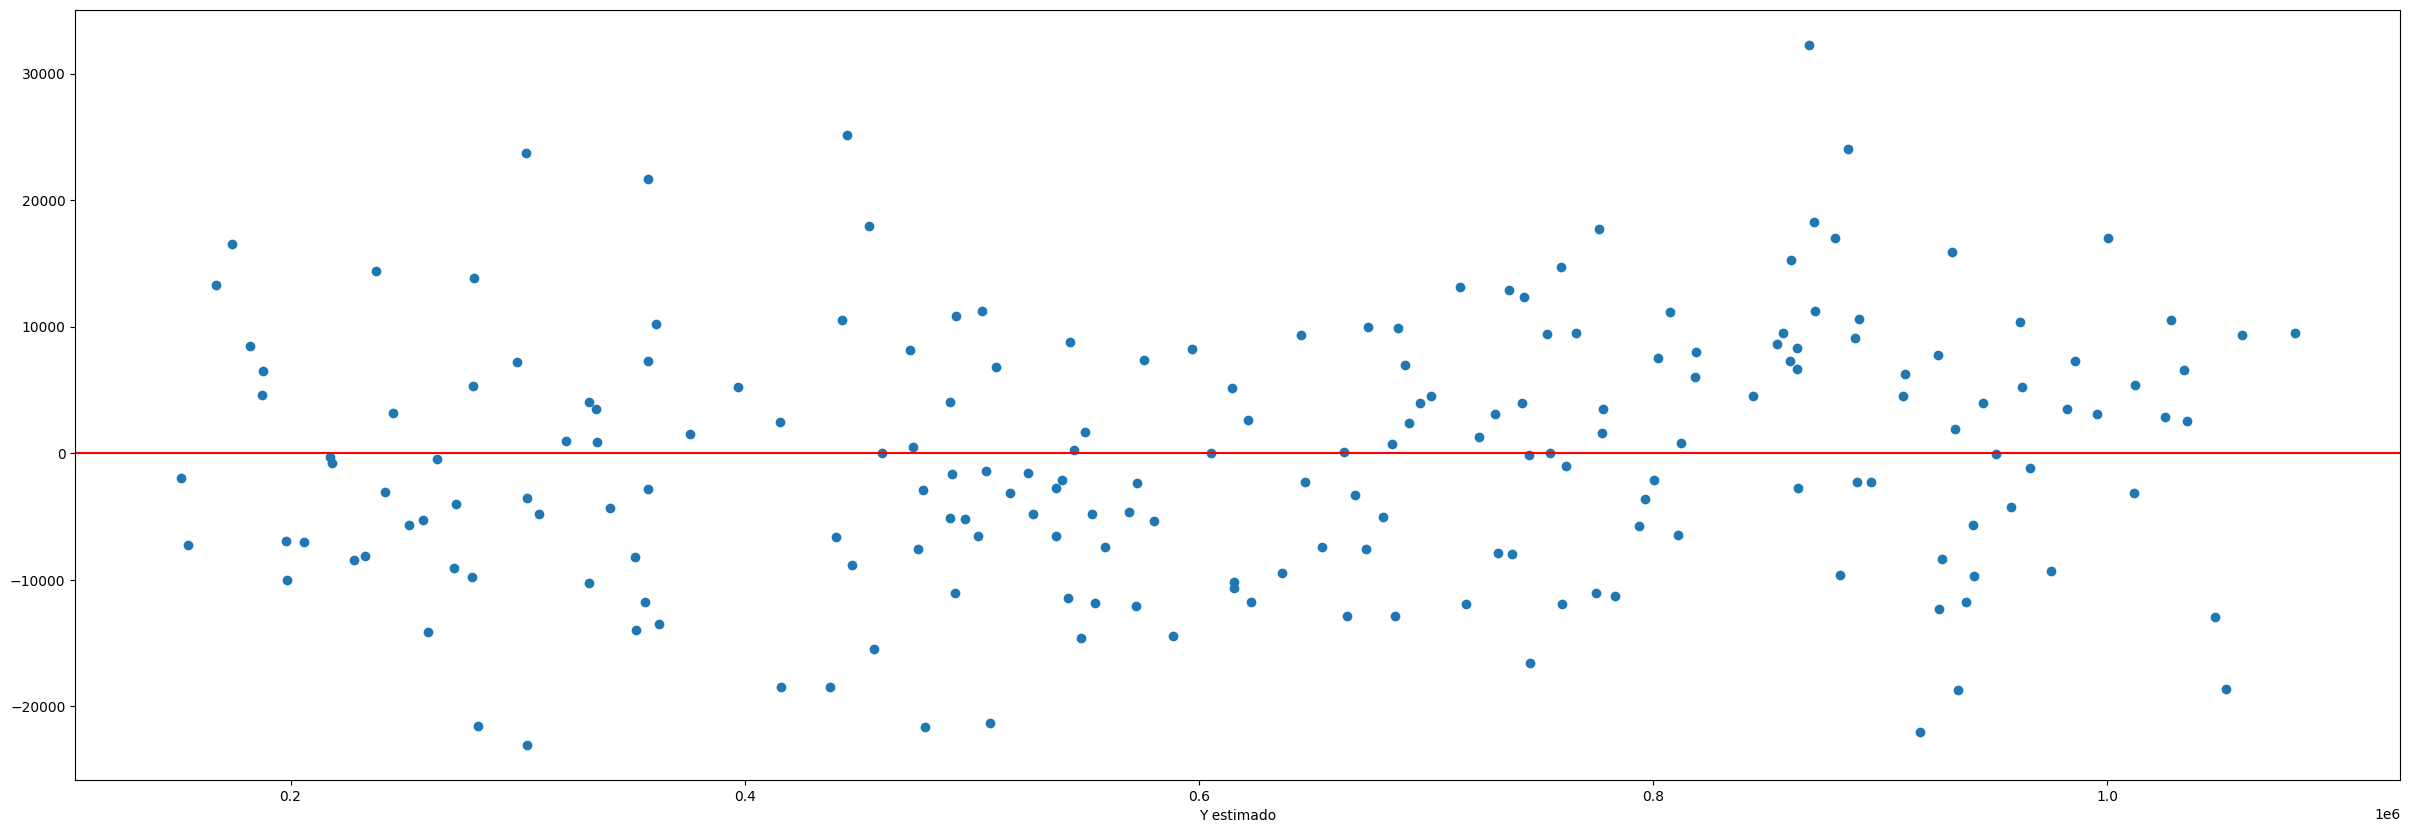

In [114]:
plt.figure(figsize=(30,10))
plt.scatter(df_modelo_padr["Y estimado"], df_modelo_padr["Residuos"])
plt.axhline(y=0, color="red")
plt.xlabel("Y estimado")
plt.show()